SETUP

In [ ]:
%pip install transformers
%pip install accelerate
%pip install safetensors
%pip install invisible-watermark>=0.2.0
%pip install omegaconf

In [ ]:
%pip install git+https://github.com/huggingface/diffusers.git@main

MODEL

In [ ]:
!wget https://civitai.com/api/download/models/148259 -O DynaVision_XL.safetensors

In [ ]:
!wget https://civitai.com/api/download/models/129610 -O 3d_style_lora.safetensors

In [ ]:
!wget https://civitai.com/api/download/models/127055/ -O anime_art_xl.safetensors

In [ ]:
!wget https://civitai.com/api/download/models/94057 -O fastnegativeV2.pt

In [ ]:
!wget https://civitai.com/api/download/models/126688 -O dreamshaper.safetensors

In [ ]:
!wget https://civitai.com/api/download/models/144566 -O samaritan3dCartoon.safetensors

SCRIPT

In [79]:
from diffusers import StableDiffusionXLPipeline, UniPCMultistepScheduler,DiffusionPipeline,StableDiffusionPipeline
import torch

# base = StableDiffusionXLPipeline.from_pretrained(
#      "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
# )
base = StableDiffusionXLPipeline.from_single_file(
     "./DynaVision_XL.safetensors", 
     torch_dtype=torch.float16, 
     variant="fp16", 
     use_safetensors=True,
    scheduler="sample_dpmpp_2m_sde"
)

base.to("cuda")
# base.load_lora_weights("./3d_style_lora.safetensors")
""" base.load_textual_inversion("./fastnegativeV2.pt") """
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=base.text_encoder_2,
    vae=base.vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)
refiner.to("cuda")

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

StableDiffusionXLImg2ImgPipeline {
  "_class_name": "StableDiffusionXLImg2ImgPipeline",
  "_diffusers_version": "0.21.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-refiner-1.0",
  "force_zeros_for_empty_prompt": false,
  "requires_aesthetics_score": true,
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    null,
    null
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    null,
    null
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [ ]:
369
high_noise_frac = 0.8

  0%|          | 0/40 [00:00<?, ?it/s]

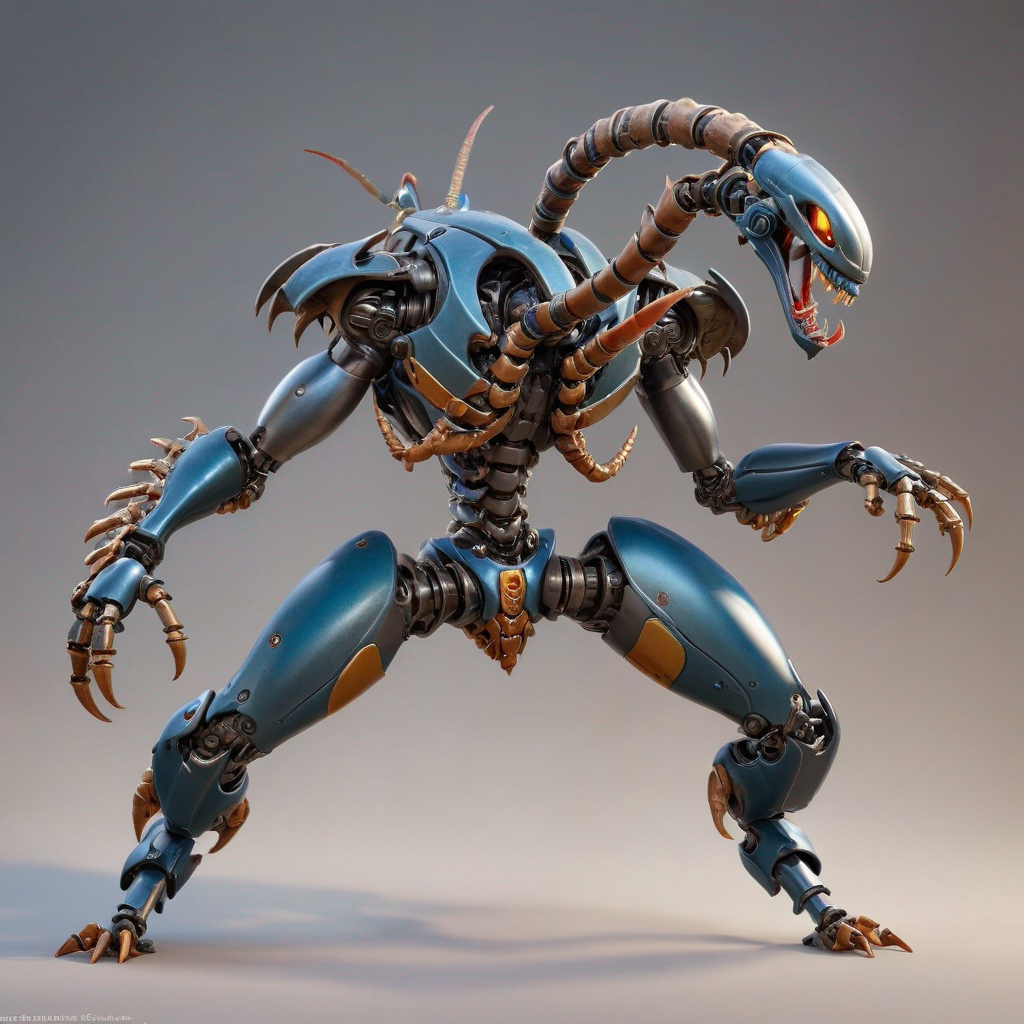

In [86]:
prompt = f'''
high quality amazing detailed art of 
an 3D stylized battle (scorpions robot),
side view ,
full body reference image for sculting
'''
neg_prompt =f''' 
low res, low quality, bad topology, bad detail, asymmetry,text
'''
image = base(
    prompt=prompt,
  num_inference_steps=n_steps,
    # denoising_end=high_noise_frac,
    # output_type="latent",
    negative_prompt=neg_prompt
).images[0]
image.show()
# image = base(
#     prompt=prompt,
#     num_inference_steps=n_steps,
#     denoising_end=high_noise_frac,
#     output_type="latent",
#     negative_prompt=neg_prompt
# ).images

# image = refiner(
#     prompt=prompt,
#     num_inference_steps=n_steps,
#     denoising_start=high_noise_frac,
#     image=image,
#     negative_prompt=neg_prompt
# ).images[0]
# image.show() 

In [85]:
name = "scorp_side2"
image.save(f"/notebooks/threestudio/load/images/{name}.png")

CONTROL NET

In [ ]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.utils import load_image
import numpy as np
import torch

import cv2
from PIL import Image

controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-canny-sdxl-1.0", torch_dtype=torch.float16
)
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", controlnet=controlnet, vae=vae, torch_dtype=torch.float16
)
pipe.enable_model_cpu_offload()



In [ ]:
prompt = "an dragon"
negative_prompt = "low quality, bad quality, sketches"



# initialize the models and pipeline
controlnet_conditioning_scale = 0.1  # recommended for good generalization
# download an image
image = Image.open("/notebooks/front.png")
# get canny image
image = np.array(image)
image = cv2.Canny(image, 100, 200)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image.show()
# generate image
image = pipe(
    prompt, controlnet_conditioning_scale=controlnet_conditioning_scale, image=canny_image
).images[0]
image.show()

DEPTH

In [ ]:
import torch
import numpy as np
from PIL import Image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL
from diffusers.utils import load_image


depth_estimator = DPTForDepthEstimation.from_pretrained("Intel/dpt-hybrid-midas").to("cuda")
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-hybrid-midas")
controlnet = ControlNetModel.from_pretrained(
    "diffusers/controlnet-depth-sdxl-1.0",
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16).to("cuda")
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    "Linaqruf/animagine-xl",
    controlnet=controlnet,
    vae=vae,
    variant="fp16",
    use_safetensors=True,
    torch_dtype=torch.float16,
).to("cuda")
# pipe.enable_model_cpu_offload()

def get_depth_map(image):
    image = feature_extractor(images=image, return_tensors="pt").pixel_values.to("cuda")
    with torch.no_grad(), torch.autocast("cuda"):
        depth_map = depth_estimator(image).predicted_depth

    depth_map = torch.nn.functional.interpolate(
        depth_map.unsqueeze(1),
        size=(1024, 1024),
        mode="bicubic",
        align_corners=False,
    )
    depth_min = torch.amin(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_max = torch.amax(depth_map, dim=[1, 2, 3], keepdim=True)
    depth_map = (depth_map - depth_min) / (depth_max - depth_min)
    image = torch.cat([depth_map] * 3, dim=1)

    image = image.permute(0, 2, 3, 1).cpu().numpy()[0]
    image = Image.fromarray((image * 255.0).clip(0, 255).astype(np.uint8))
    return image




In [ ]:
import torch
import numpy as np
from PIL import Image

from transformers import DPTFeatureExtractor, DPTForDepthEstimation
from diffusers import ControlNetModel, StableDiffusionXLControlNetPipeline, DiffusionPipeline
from diffusers.utils import load_image
refiner = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-refiner-1.0",
    text_encoder_2=pipe.text_encoder_2,
    vae=vae,
    torch_dtype=torch.float16,
    use_safetensors=True,
    variant="fp16"
)
""" refiner.load_lora_weights("./3d_style_lora.safetensors") """
refiner.to("cuda")


In [ ]:
n_steps = 50
high_noise_frac = 0.9

In [ ]:

prompt = f'''
an cat like pokemon,masterpiece, best quality,in forest
'''
neg_prompt =f''' 
lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry
'''
image = Image.open("/notebooks/front.png").convert("RGB")
controlnet_conditioning_scale = 0.6  # recommended for good generalization

depth_image = get_depth_map(image)

image = pipe(
    prompt,
    negative_prompt=neg_prompt, 
    image=depth_image,
    num_inference_steps=n_steps,
    # denoising_start=high_noise_frac,
    output_type="latent",
    controlnet_conditioning_scale=controlnet_conditioning_scale,
    
).images


In [ ]:
image = refiner(
    prompt=prompt,
    num_inference_steps=n_steps,
#    denoising_start=high_noise_frac,
    image=image,
    negative_prompt=neg_prompt
).images[0]
image.show() 